In [224]:
import numpy as np
import time,datetime

from PIL import Image
import matplotlib.pyplot as plt
from keras import backend as K


In [342]:
data_path  = "C:\\Users\\ЛФКИТ-3\\Documents\\Interferom\\img\\seq\\"

import os
filenames = os.listdir(data_path)[:-20]
def image_gen(filenames):
    print('reading %i files'%len(filenames))
    for filename in filenames:
        try:
            yield Image.open(data_path+filename)
        except OSError as e:
            print(e)

def values_gen(filenames):
    start_time= time.mktime((2018,5,24,20,34,0,0,0,0))
    val_changed = start_time
    val = 0
    for f in filenames:
        t = (os.stat(data_path+f).st_mtime)
        date = datetime.datetime.fromtimestamp(t)
        #print(date.strftime('%Y-%m-%d %H:%M:%S'))
        #print(val_changed,t)
        if val_changed< t < val_changed+4:
            yield val
        if t>val_changed+4:
            val_changed+=10 # Next measurment series in 10 sec
            val+=1
            yield -1

In [343]:
def preprocess_func(im):
    # get only red channel
    factor = 16
    shape = [im.size[0]//factor,im.size[1]//factor]
    im = im.resize((im.size[0]//factor,im.size[1]//factor))
    processed = np.array(im)[:,:,0]
    return processed#.reshape(*([1]+shape))

In [344]:
a = [preprocess_func(im) for im in image_gen(filenames)]
v = [s for s in values_gen(filenames)]


reading 568 files


(64, 80)

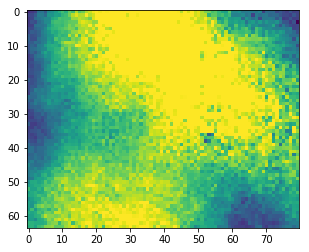

In [345]:
plt.imshow(a[0])
a[0].shape

In [346]:
print(a[0].shape)
X = np.array([im for im,v in zip(a,v) if v>0])
y = np.array(([_v for _v in v if _v>0]))
IMAGE_SHAPE = a[0].shape
channels = 1
img_rows,img_cols = IMAGE_SHAPE
if K.image_data_format() == 'channels_first':
    X = X.reshape(X.shape[0], channels, img_rows, img_cols)
    input_shape = (channels, img_rows, img_cols)
else:
    X = X.reshape(X.shape[0], img_rows, img_cols, channels)
    input_shape = (img_rows, img_cols, channels)

(64, 80)


In [373]:
import keras
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense,Flatten
from keras.layers import Conv2D, MaxPooling2D
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from keras import optimizers
from keras.callbacks import LearningRateScheduler


In [426]:
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 80.0
    lrate = initial_lrate * np.power(drop,  
           np.floor((1+epoch)/epochs_drop))
    print(epoch,lrate)
    return lrate
lrate_clb = LearningRateScheduler(step_decay)
lrate = 0.001

In [427]:
# define base model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(5, 5), activation='relu', 
                     padding='same', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(24, kernel_size=(3, 3), activation='relu', 
                 padding='same', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(12, kernel_size=(3, 3), activation='relu', 
             padding='same', input_shape=input_shape))
    model.add(Flatten())
    model.add(Dense(13, input_dim=32, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    o =keras.optimizers.RMSprop(lr=lrate, rho=0.8, epsilon=1e-6)
    model.compile(loss='mean_squared_error', optimizer=o)
    print(model.summary())
    return model

In [428]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=100, batch_size=5, verbose=0)


In [429]:
kfold = KFold(n_splits=10, random_state=seed)
#results = cross_val_score(estimator, X, y, cv=kfold, n_jobs=1)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Results: -136.95 (138.31) MSE


In [449]:

####
####
callbacks_list = [lrate_clb]
print(X.shape,y.shape)
model = baseline_model()
train_size = 30
history = model.fit(X[:30], y[:30],
                    callbacks=callbacks_list, 
                    epochs=500)


(91, 64, 80, 1) (91,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_49 (Conv2D)           (None, 64, 80, 32)        832       
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 32, 40, 32)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 32, 40, 24)        6936      
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 16, 20, 24)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 16, 20, 12)        2604      
_________________________________________________________________
flatten_17 (Flatten)         (None, 3840)              0         
_________________________________________________________________
dense_33 (Dense)             (None, 13)               

Epoch 76/500
75 0.001
30/30 [==============================] - 0s 8ms/step - loss: 17.3471
Epoch 77/500
76 0.001
30/30 [==============================] - 0s 8ms/step - loss: 19.3083
Epoch 78/500
77 0.001
30/30 [==============================] - 0s 8ms/step - loss: 18.0209
Epoch 79/500
78 0.001
30/30 [==============================] - 0s 8ms/step - loss: 22.0143
Epoch 80/500
79 0.0005
30/30 [==============================] - 0s 8ms/step - loss: 18.3139
Epoch 81/500
80 0.0005
30/30 [==============================] - 0s 8ms/step - loss: 16.2177
Epoch 82/500
81 0.0005
30/30 [==============================] - 0s 7ms/step - loss: 15.8568
Epoch 83/500
82 0.0005
30/30 [==============================] - 0s 8ms/step - loss: 15.7794
Epoch 84/500
83 0.0005
30/30 [==============================] - 0s 8ms/step - loss: 15.7385
Epoch 85/500
84 0.0005
30/30 [==============================] - 0s 6ms/step - loss: 15.7014
Epoch 86/500
85 0.0005
30/30 [==============================] - 0s 7ms/step - loss: 

Epoch 164/500
163 0.00025
30/30 [==============================] - 0s 8ms/step - loss: 13.0698
Epoch 165/500
164 0.00025
30/30 [==============================] - 0s 8ms/step - loss: 13.0175
Epoch 166/500
165 0.00025
30/30 [==============================] - 0s 8ms/step - loss: 12.9815
Epoch 167/500
166 0.00025
30/30 [==============================] - 0s 8ms/step - loss: 12.9512
Epoch 168/500
167 0.00025
30/30 [==============================] - 0s 8ms/step - loss: 12.9156
Epoch 169/500
168 0.00025
30/30 [==============================] - 0s 9ms/step - loss: 12.8948
Epoch 170/500
169 0.00025
30/30 [==============================] - 0s 8ms/step - loss: 12.8370
Epoch 171/500
170 0.00025
30/30 [==============================] - 0s 8ms/step - loss: 12.8134
Epoch 172/500
171 0.00025
30/30 [==============================] - 0s 8ms/step - loss: 12.7154
Epoch 173/500
172 0.00025
30/30 [==============================] - 0s 8ms/step - loss: 12.7436
Epoch 174/500
173 0.00025
30/30 [=================

30/30 [==============================] - 0s 8ms/step - loss: 9.6532
Epoch 251/500
250 0.000125
30/30 [==============================] - 0s 8ms/step - loss: 9.7445
Epoch 252/500
251 0.000125
30/30 [==============================] - 0s 8ms/step - loss: 9.6250
Epoch 253/500
252 0.000125
30/30 [==============================] - 0s 8ms/step - loss: 9.4092
Epoch 254/500
253 0.000125
30/30 [==============================] - 0s 9ms/step - loss: 9.3183
Epoch 255/500
254 0.000125
30/30 [==============================] - 0s 8ms/step - loss: 9.2750
Epoch 256/500
255 0.000125
30/30 [==============================] - 0s 8ms/step - loss: 9.2662
Epoch 257/500
256 0.000125
30/30 [==============================] - 0s 9ms/step - loss: 9.3371
Epoch 258/500
257 0.000125
30/30 [==============================] - 0s 8ms/step - loss: 9.3910
Epoch 259/500
258 0.000125
30/30 [==============================] - 0s 8ms/step - loss: 9.4490
Epoch 260/500
259 0.000125
30/30 [==============================] - 0s 8ms/st

Epoch 337/500
336 6.25e-05
30/30 [==============================] - 0s 9ms/step - loss: 6.8178
Epoch 338/500
337 6.25e-05
30/30 [==============================] - 0s 9ms/step - loss: 6.7911
Epoch 339/500
338 6.25e-05
30/30 [==============================] - 0s 9ms/step - loss: 6.7688
Epoch 340/500
339 6.25e-05
30/30 [==============================] - 0s 9ms/step - loss: 6.7602
Epoch 341/500
340 6.25e-05
30/30 [==============================] - 0s 10ms/step - loss: 6.7398
Epoch 342/500
341 6.25e-05
30/30 [==============================] - 0s 8ms/step - loss: 6.7565
Epoch 343/500
342 6.25e-05
30/30 [==============================] - 0s 8ms/step - loss: 6.7626
Epoch 344/500
343 6.25e-05
30/30 [==============================] - 0s 8ms/step - loss: 6.7584
Epoch 345/500
344 6.25e-05
30/30 [==============================] - 0s 8ms/step - loss: 6.7683
Epoch 346/500
345 6.25e-05
30/30 [==============================] - 0s 8ms/step - loss: 6.7008
Epoch 347/500
346 6.25e-05
30/30 [===============

Epoch 423/500
422 3.125e-05
30/30 [==============================] - 0s 8ms/step - loss: 5.3763
Epoch 424/500
423 3.125e-05
30/30 [==============================] - 0s 9ms/step - loss: 5.3697
Epoch 425/500
424 3.125e-05
30/30 [==============================] - 0s 8ms/step - loss: 5.3779
Epoch 426/500
425 3.125e-05
30/30 [==============================] - 0s 9ms/step - loss: 5.3646
Epoch 427/500
426 3.125e-05
30/30 [==============================] - 0s 8ms/step - loss: 5.3512
Epoch 428/500
427 3.125e-05
30/30 [==============================] - 0s 8ms/step - loss: 5.3291
Epoch 429/500
428 3.125e-05
30/30 [==============================] - 0s 8ms/step - loss: 5.3159
Epoch 430/500
429 3.125e-05
30/30 [==============================] - 0s 8ms/step - loss: 5.3022
Epoch 431/500
430 3.125e-05
30/30 [==============================] - 0s 8ms/step - loss: 5.2918
Epoch 432/500
431 3.125e-05
30/30 [==============================] - 0s 8ms/step - loss: 5.2701
Epoch 433/500
432 3.125e-05
30/30 [=====

In [452]:
print("std of y",np.std(y))
print("mean of y",np.mean(y))
print("constant performance is",np.std(y)**2)
#print("zero performance is",np.std(y))

print(model.summary())

std of y 12.672469154020707
mean of y 22.186813186813186
constant performance is 160.5914744596063
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_49 (Conv2D)           (None, 64, 80, 32)        832       
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 32, 40, 32)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 32, 40, 24)        6936      
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 16, 20, 24)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 16, 20, 12)        2604      
_________________________________________________________________
flatten_17 (Flatten)         (None, 3840)              0         
___________________________________________

In [455]:
## EVAL
idx, sz = 0,50
pred = model.predict(X[idx:idx+sz])
print(y[idx:idx+sz])
print(pred)

[ 1  1  2  2  3  3  4  4  4  5  5  6  6  7  7  8  8  9  9 10 10 11 11 12
 12 13 13 13 14 14 15 15 16 16 17 17 18 18 19 19 20 20 21 21 22 22 22 23
 23 24]
[[ 2.9702027]
 [ 3.7042031]
 [ 4.14415  ]
 [ 3.048348 ]
 [ 7.185736 ]
 [ 6.194061 ]
 [ 4.6728196]
 [ 5.41518  ]
 [ 3.7552822]
 [ 6.635601 ]
 [ 4.943546 ]
 [ 7.318089 ]
 [ 7.8214917]
 [ 6.5751843]
 [ 7.298181 ]
 [ 6.901817 ]
 [ 7.894488 ]
 [ 9.551009 ]
 [ 8.863787 ]
 [10.14226  ]
 [10.106576 ]
 [11.491314 ]
 [ 9.850044 ]
 [11.70904  ]
 [10.00363  ]
 [ 7.9849734]
 [ 9.34111  ]
 [10.02232  ]
 [11.092826 ]
 [ 9.494898 ]
 [ 6.882344 ]
 [ 8.024454 ]
 [ 9.604464 ]
 [ 9.035787 ]
 [ 5.846127 ]
 [ 4.493604 ]
 [ 6.279286 ]
 [ 6.2758584]
 [ 5.5737963]
 [ 5.1775284]
 [ 5.7944303]
 [ 6.5993066]
 [ 5.170467 ]
 [ 5.989575 ]
 [ 7.801417 ]
 [ 6.974812 ]
 [ 8.033179 ]
 [ 5.8707995]
 [ 6.20362  ]
 [ 9.018715 ]]


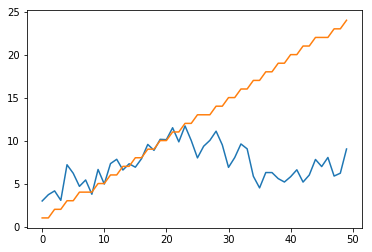

In [456]:
plt.plot(pred.reshape(-1))
plt.plot(y[idx:idx+sz])


In [ ]:
K.clear_session()